# Example 4.5: Calculating Code Words
In this notebook, we illustrate the operation of the code words algorithm. 

We start with a set of XP operators $\mathbf{G}$ which are the generators of the stabilizer code:

To run different scenarios click here: [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/m-webster/XPFpackage/HEAD?urlpath=tree/Examples)

This code is Copyright 2021-22 Mark Webster, and is made available subject to [GPL licensing](https://www.gnu.org/licenses/gpl-3.0.en.html).

In [1]:
import add_parent_dir
import numpy as np
from common import *
from NSpace import *
from XPAlgebra import *
from XPCodes import *
%matplotlib inline

## Code 1
genstr = 'XP_8(8|0000000|6554444),XP_8(7|1111111|1241234),XP_8(1|1110000|3134444)'

## Code 2
# genstr = 'XP8(0|0000000|1322224),XP8(12|1111111|1234567)'

## Code 3
# genstr = 'XP_2(0|000|110)'

## Code 4
# genstr = 'XP_16(0|0000|8 12 14 7),XP_16(0|0000|8 4 10 13)'


G, N = str2XP(genstr)
G = ZMat2D(G)
n = XPn(G)
print(f'The code is precision N={N} on n={n} qubits.')
print('\n')
print('The Code Generators are G:')
print(XP2Str(G,N),"\n")


The code is precision N=8 on n=7 qubits.


The Code Generators are G:
XP_8( 8|0000000|6554444)
XP_8( 7|1111111|1241234)
XP_8( 1|1110000|3134444) 



## Step 1: Canonical Generators
The canonical generators $ \mathbf{S}_X,\mathbf{S}_Z $ for the code are:


In [2]:
S = CanonicalGenerators(G,N)
SX,SZ = splitDiag(S)
print('SX:')
print(XP2Str(SX,N))
print('SZ:')
print(XP2Str(SZ,N))

SX:
XP_8( 9|1110000|1240000)
XP_8(14|0001111|0001234)
SZ:
XP_8( 8|0000000|2334444)
XP_8( 0|0000000|0440000)


## Step 2: Orbit Representatives
We calculate $S_{Zp}$ by taking the phase and Z components each element $B$ of $\mathbf{S}_Z$.

If $B = XP_N(p|\mathbf{x}|\mathbf{z})$ then $S_{Zp}(B) = (\mathbf{z}|p/2)$.

The Simultaneous $+1$ eigenspace of $\mathbf{S}_Z$ is given by the binary vectors $\mathbf{e}$ such that:

$$S_{Zp} (\mathbf{e}|1)  \mod N = \mathbf{0}$$

Solutions are of form $(\mathbf{e}|1) = a K \mod N$ where $K$ is a Howell basis of $\ker(S_{Zp})$ and $\mathbf{a}$ is a vector of length $|K|$ with entries in $\mathbb{Z}_N$.

The exhaustive algorithm adds all possible linear combinations of rows of $K$ and the solutions are those sums which result in a binary vector of form $(\mathbf{e}|1) = \mathbf{a}K \mod N$ for some combination represented by the vector $\mathbf{a}$. This is of exponential complexity.

The optimised graph search algorithm reduces the size of the search space by setting $\mathbf{e}[l] = 0$ whenever $l$ is a leading index of $S_X$, where $S_X$ is the matrix formed from the X components of the canonical generators.

The graph search algorithm outputs a matrix $A$ such that each row $\mathbf{a}$ of $A$ is a valid combination yielding a binary vector of the required form.

The orbit representatives $E_m$ are the rows of $AK \mod N$ but with the final column of all 1's dropped:

SZp: Z components and phase of diagonal canonical generators:
23344444
04400000


K: Howell basis of Kernel of SZp:
10200000
01300001
00400001
00010001
00001001
00000101
00000011
00000002


SXx: X components of non-diagonal canoncial generators SX:
1110000
0001111


Li: The leading indices of SXx:
[0, 3]




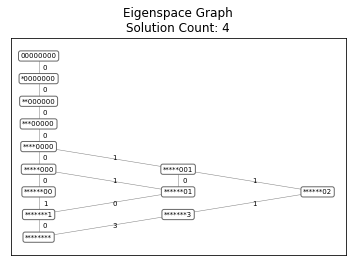

Graph Search Algorithm yields the following solutions A:
00000010
00000100
00001000
00001113


AK mod N:
00000011
00000101
00001001
00001111


Em: drop the final column of all 1's from AK mod N:
0000001
0000010
0000100
0000111




In [3]:
SZp = XP2Zp(SZ,N,double=False)
print('SZp: Z components and phase of diagonal canonical generators:')
print(ZmatPrint(SZp,N))
print('\n')

nsp = NSpace(SZp,N)
nsp.simplifyKer()
K = nsp.K

print('K: Howell basis of Kernel of SZp:')
print(ZmatPrint(K,N))
print('\n')

SXx = XPx(SX)
print('SXx: X components of non-diagonal canoncial generators SX:')
print(ZmatPrint(SXx,2))
print('\n')

print('Li: The leading indices of SXx:')
li = leadingIndices(SXx)
print(li)
print('\n')

x = ZMat([2]*(n+1))
x[li] = 0
x[-1] = 1

###### Calculate the solution graph D by calling espaceSolve
# D is the graph
# (n,b) is the starting node for the solution
D,(n,b) = espaceSolve(K,N,b=None,x=x)

###### convert graph D to a list L
# L is a list of vectors c modulo N of length m
# representing linear combinations of the rows of K

displayGraph(D,(n,b),'Eigenspace Graph',K)

A = graph2List(D,(n,b),rev=True)
A = ZMat(A)

print('Graph Search Algorithm yields the following solutions A:')
print(ZmatPrint(A,N))
print('\n')
Em = np.mod(A @ K,N)
print('AK mod N:')
print(ZmatPrint(Em,2))
print('\n')
print('Em: drop the final column of all 1\'s from AK mod N:')
Em = Em[:,:-1]
print(ZmatPrint(Em,2))
print('\n')

## Step 3: Image of Orbit Representatives under Orbit Operator is a Basis of the Code Space

We first calculate the orbit operator $O_{\mathbf{S}_X}$, then apply $O_{\mathbf{S}_X}$ to each element of $E_m$ to generate the codewords:

In [4]:
OSx,LIx = OrbitOperator(SX,N)
print('Orbit operator OSx is the sum of the following XP operators:')
print(XP2Str(OSx,N))
print('\n')
print('Applying OSx to each element of Em yields the code words:')
EmState = makeXP(0,Em,0)
EmStr = ZMat2str(Em,2)
for i in range(len(Em)):
    m = EmState[i]
    k = XPMul(OSx,m,N)
    print(f'|k_{i}> = OSx|{EmStr[i]}> = {State2Str(k,N)}')

Orbit operator OSx is the sum of the following XP operators:
XP_8( 0|0000000|0000000)
XP_8( 9|1110000|1240000)
XP_8(14|0001111|0001234)
XP_8( 7|1111111|1241234)


Applying OSx to each element of Em yields the code words:
|k_0> = OSx|0000001> = |0000001>+w6/16|0001110>+w9/16|1110001>+w15/16|1111110>
|k_1> = OSx|0000010> = |0000010>+w4/16|0001101>+w9/16|1110010>+w13/16|1111101>
|k_2> = OSx|0000100> = |0000100>+w2/16|0001011>+w9/16|1110100>+w11/16|1111011>
|k_3> = OSx|0000111> = |0000111>+|0001000>+w9/16|1110111>+w9/16|1111000>
